# Create and plot Green's functions & reconstructions

## Modules, functions, and settings

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xcdat as xc
import matplotlib as mpl
import importlib as imp
from cartopy.util import add_cyclic_point
from cmcrameri import cm

from _model_settings import DIR, model_dct
import plotting

Host: pie-node2


In [2]:
SAVE_FIGURES = True
SHOW_COLORBAR = False

In [3]:
def get_global_avg(ds,var,mod_dct):

    # Weights
    weights = np.cos(np.deg2rad(ds[mod_dct['lat_name']]))
    weights.name = "weights"

    # Weighted mean
    da_weighted = ds[var].weighted(weights)
    global_mean = da_weighted.mean((mod_dct['lon_name'], mod_dct['lat_name']), skipna=True)

    return global_mean


def get_ocean_avg(ds,var,mod_dct):

    # Get ocean area
    weights = xr.DataArray(mod_dct['ocean_area'],
        coords={
            mod_dct['lat_name']: mod_dct['lat'],
            mod_dct['lon_name']: mod_dct['lon'],
        },name='weights')

    da_weighted = ds[var].weighted(weights)
    ocean_mean = da_weighted.mean((mod_dct['lon_name'], mod_dct['lat_name']), skipna=True).values

    return ocean_mean

def write_line(f, x, y):
    f.write(str(x))
    f.write(" ")
    f.write(str(y))
    f.write("\n")

In [4]:
# Get settings
var = 'R'
model_list = ['era','eam','fv3']
ds_mod = {}
for model in model_list:
    ds_mod[model] = model_dct[model]
    ds_mod[model]['var'] = ds_mod[model][var+'_name']
    if model=='era':
        ds_mod[model]['A_list'] = ['2K','-2K','4K','-4K']
    else:
        ds_mod[model]['A_list'] = ['2K','-2K']

## Load simulations, patches, ocean area, etc.

In [5]:
# Load patches etc.
for model in model_list:
    dct = ds_mod[model]
    
    ds_vars = []
    for A in dct['A_list']:
        # Load patches
        dct['patches_'+A] = xc.open_dataset(\
            DIR+'forcing/'+model+'/GFMIP_patches_'+A+'.nc',\
            decode_times=False\
        )
        dct['patch_list_'+A] = [item for item in list(dct['patches_'+A].keys()) if item.startswith('patch')]

        ds_vars.append(\
            xc.open_dataset(DIR+'output/'+model+'/R_gm_monthly_'+A+'.nc',\
        ).bounds.add_missing_bounds())
    dct['vars_gm_monthly'] = xr.merge(ds_vars)

    # Load mask
    ds_mask = xc.open_dataset(DIR+'output/'+model+'/ocean_mask.nc',decode_times=False)

    # Save grid
    dct['lat'] = ds_mask[dct['lat_name']].values
    dct['lon'] = ds_mask[dct['lon_name']].values
    dct['grid'] = ds_mask.regridder.grid

    # Save mask
    dct['ocean_mask'] = ds_mask['ocean_fraction'].values

    # Get ocean area
    area = np.cos(np.deg2rad(dct['lat']))
    dct['ocean_area'] = area[:,np.newaxis] * dct['ocean_mask']
    dct['ocean_area'] = dct['ocean_area']/np.sum(dct['ocean_area'])
    
    # Decode control time
    dct['control_vars_monthly'] = xc.decode_time(\
            dct['vars_gm_monthly'][\
                [item for item in list(dct['vars_gm_monthly'].keys()) if item.endswith('control')]\
            ].rename({'time_control':'time'})\
        ).sel(time=slice('2021-01-01','2040-12-31'))\
        .bounds.add_missing_bounds()

## Create Green's functions

In [6]:
for mod in model_list:
    dct = ds_mod[mod]

    # Get global mean response; last 10 years only
    response_dct = dct['vars_gm_monthly'].sel(time=slice('2023-01-01','2032-12-31'))

    # Get control
    dct['control'] = dct['control_vars_monthly'].temporal.average(dct['var']+'_control')[dct['var']+'_control'].values

    # Loop over patch amplitudes
    for A in dct['A_list']:
        patch_lst = dct['patch_list_'+A]
        patch_dct = dct['patches_'+A]

        # Initialize numerator and denominator
        dR_dSST_num = np.zeros(\
            (dct['lat'].size,dct['lon'].size))
        dR_dSST_den = np.zeros(\
            (dct['lat'].size,dct['lon'].size))
        
        # Sum over all patches
        for ii, patch_loc in enumerate(patch_lst):
            # Get patch info
            patch_avg = get_ocean_avg(patch_dct,patch_loc,dct)
            patch_map = patch_dct[patch_loc].values

            # If patch is entirely over land/ice, skip
            if np.all(patch_avg==0.):
                continue
            
            # Get patch response anomaly
            dR = response_dct.temporal.average(dct['var']+'_'+patch_loc)[dct['var']+'_'+patch_loc].values - dct['control']

            # Add to numerator and denominator
            dR_dSST_num += (patch_map/patch_avg)*dR
            dR_dSST_den += patch_map
        
        # Create normalized Green's function
        dR_dSST_den[dR_dSST_den==0] = np.nan
        dct['dR_dSST_star_'+A] = dR_dSST_num/dR_dSST_den

        # Apply mask
        dct['dR_dSST_star_'+A] = dct['dR_dSST_star_'+A]*dct['ocean_mask']
        dct['dR_dSST_star_'+A][np.isnan(dct['dR_dSST_star_'+A])] = 0.
    
    # Average Green's functions
    dct['dR_dSST_star_a2K'] = (dct['dR_dSST_star_2K']+dct['dR_dSST_star_-2K'])/2
    dct['A_list'].append('a2K')
    if mod=='era':
        dct['dR_dSST_star_a4K'] = (dct['dR_dSST_star_4K']+dct['dR_dSST_star_-4K'])/2
        dct['A_list'].append('a4K')

## Plot Green's functions

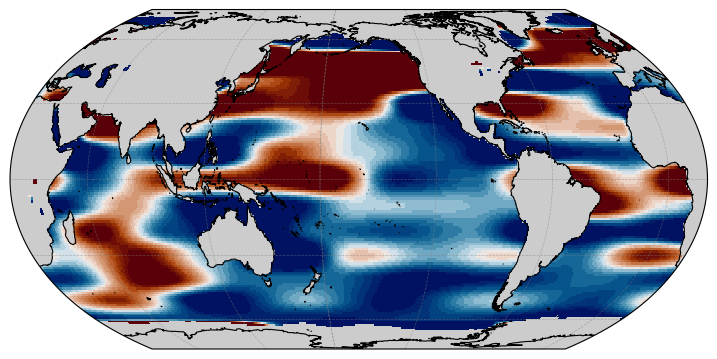

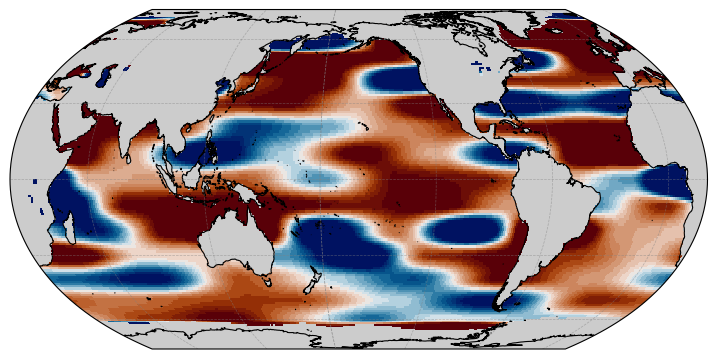

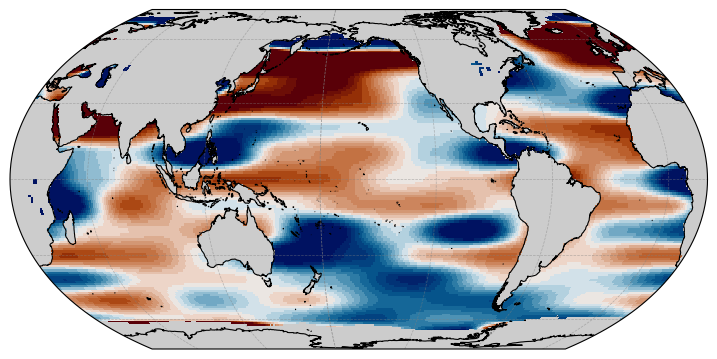

In [7]:
imp.reload(plotting)

# Limits
l = np.linspace(-25,25,26)
t = np.linspace(-20,20,5)
norm = mpl.colors.BoundaryNorm(l, cm.vik.N)

# Plot all Green's functions
for ii, mod in enumerate(model_list):
    dct = ds_mod[mod]
    for jj, A in enumerate(dct['A_list']):
        fig, ax = plotting.setup_figure("global",nCols=1,nRows=1,size=(9,10),mask=False)
        ax.set_facecolor((0.8,0.8,0.8))

        # Cyclic boundaries
        GF_cyc, lon_cyc = add_cyclic_point(dct['dR_dSST_star_'+A],coord=dct['lon'])

        # Mask out land areas
        GF_cyc[GF_cyc==0] = np.nan

        cf=ax.pcolormesh(lon_cyc,dct['lat'],GF_cyc,norm=norm,transform=plotting.data_crs,cmap=cm.vik)
        if SHOW_COLORBAR:
            cb = plt.colorbar(cf,ax=ax, orientation = "horizontal",shrink=1.0, extend='both',ticks=t)
            cb.set_label("Green's function "+A+" [Wm$^{-2}$K$^{-1}$]")
            ax.set_title(dct['name'])

        if SAVE_FIGURES:
            fig.savefig("./figures/gf_"+mod+"_"+A+".png",bbox_inches='tight',pad_inches = 0,dpi=300)
        plt.show()

## Plot historical net ToA reconstruction

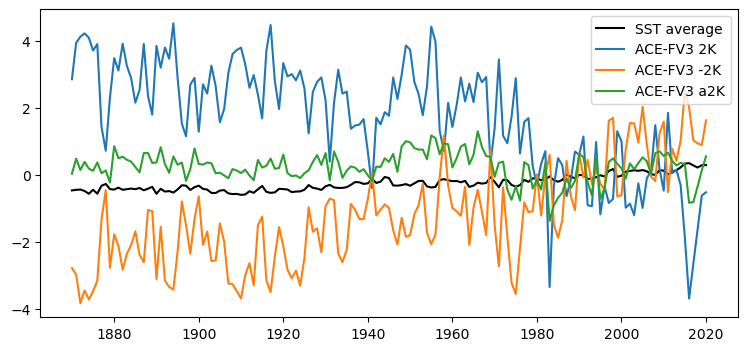

In [12]:
imp.reload(plotting)

# Get historical SST
ds_hist = xc.open_dataset(\
        DIR+'forcing/AMIP/historical.nc'\
    ).bounds.add_missing_bounds()\
    .sel(time=slice('1870-01-01','2020-12-31'))\
    .temporal.group_average('sst anomaly','year')
yr = np.arange(1870,2021)

fig, ax = plt.subplots(1,1,figsize=(9,4))
for ii, mod in enumerate(model_list):
    dct = ds_mod[mod]

    # Regrid historical SST to ACE grid
    hist_sst = ds_hist.regridder.horizontal(\
        'sst anomaly', \
        dct['grid'], \
        tool='xesmf', \
        method='conservative', \
        periodic=True \
    )
    
    # Reshape SST for matrix multiplication
    sst = np.reshape(hist_sst['sst anomaly'].values,(yr.size,-1))

    for A in dct['A_list']:
        # Reshape Green's function for matrix multiplication
        GF_flat = np.reshape(dct['dR_dSST_star_'+A]*dct['ocean_area'],(-1))
        GF_pred = sst.copy() @ GF_flat

        # Plot predictions
        ax.plot(yr,GF_pred,label=dct['name']+" "+A)
        if SAVE_FIGURES:
            with open("./figures/R_"+mod+"_"+A+".dat","w") as f:
                for jj in range(yr.size):
                    write_line(f, yr[jj], GF_pred[jj])
ax.legend()
plt.show()